In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
pd.options.display.max_columns = None

In [2]:
PATH_DATA_RAW= '../Dataset/Raw/'
PATH_DATA_CLEAN = '../Dataset/Clean/'

In [3]:
df = joblib.load(PATH_DATA_CLEAN+'dataset_modeling_day.pkl')
df.head()

,calendar_date,total_trip,holiday,is_weekend
0,2019-05-01,1,1,0
1,2019-05-02,345,0,0
2,2019-05-03,14393,0,0
3,2019-05-04,16660,0,1
4,2019-05-05,17285,0,1


# Cut data and Convert to Time Series Index

In [4]:
df = df.drop([0,1,2,3,4])
df.set_index('calendar_date', inplace=True)

In [5]:
df.head()

,total_trip,holiday,is_weekend
calendar_date,,,
2019-05-06,14448,0,0
2019-05-07,13819,0,0
2019-05-08,14841,0,0
2019-05-09,14744,0,0
2019-05-10,15839,0,0


In [6]:
df = df.asfreq('d')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 141 entries, 2019-05-06 to 2019-09-23
Freq: D
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   total_trip  141 non-null    int64
 1   holiday     141 non-null    int64
 2   is_weekend  141 non-null    int64
dtypes: int64(3)
memory usage: 4.4 KB


In [7]:
size = int(len(df)*0.8)
size

112

In [8]:
df_train = df.iloc[:size]
df_test = df.iloc[size:]

In [9]:
df_train.tail(), df_test.head()

(               total_trip  holiday  is_weekend
 calendar_date                                 
 2019-08-21          14605        0           0
 2019-08-22          15158        0           0
 2019-08-23          15448        0           0
 2019-08-24          17518        0           1
 2019-08-25          17716        0           1,
                total_trip  holiday  is_weekend
 calendar_date                                 
 2019-08-26          14770        0           0
 2019-08-27          13978        0           0
 2019-08-28          14454        0           0
 2019-08-29          15201        0           0
 2019-08-30          15340        0           0)

# SARIMA and SARIMAX

## Cek komponen deret waktu

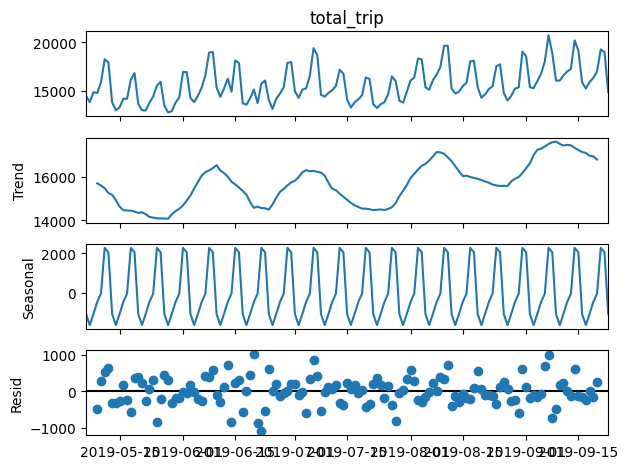

In [10]:
import statsmodels.api as sm
dec = sm.tsa.seasonal_decompose(df['total_trip'],period = 7, model = 'additive').plot()
plt.show()

In [11]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=7).mean()
    MSTD = timeseries.rolling(window=7).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [12]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

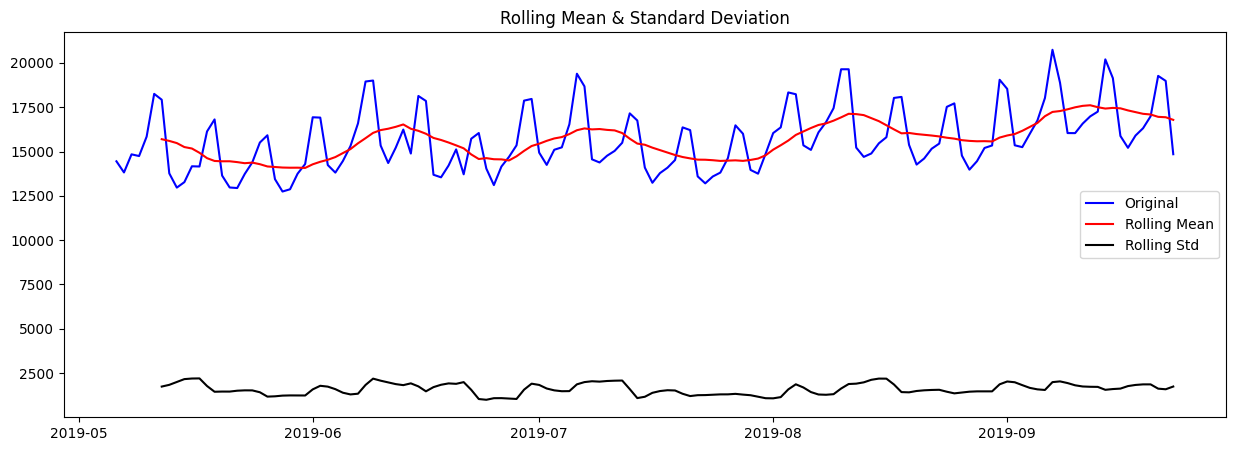

Results of Dickey-Fuller Test:
Test Statistic                  -3.682207
p-value                          0.004370
#Lags Used                       9.000000
Number of Observations Used    131.000000
Critical Value (1%)             -3.481282
Critical Value (5%)             -2.883868
Critical Value (10%)            -2.578677
dtype: float64


In [13]:
test_stationarity(df['total_trip'])

p-value < 0.05, H0 ditolak, data stasioner

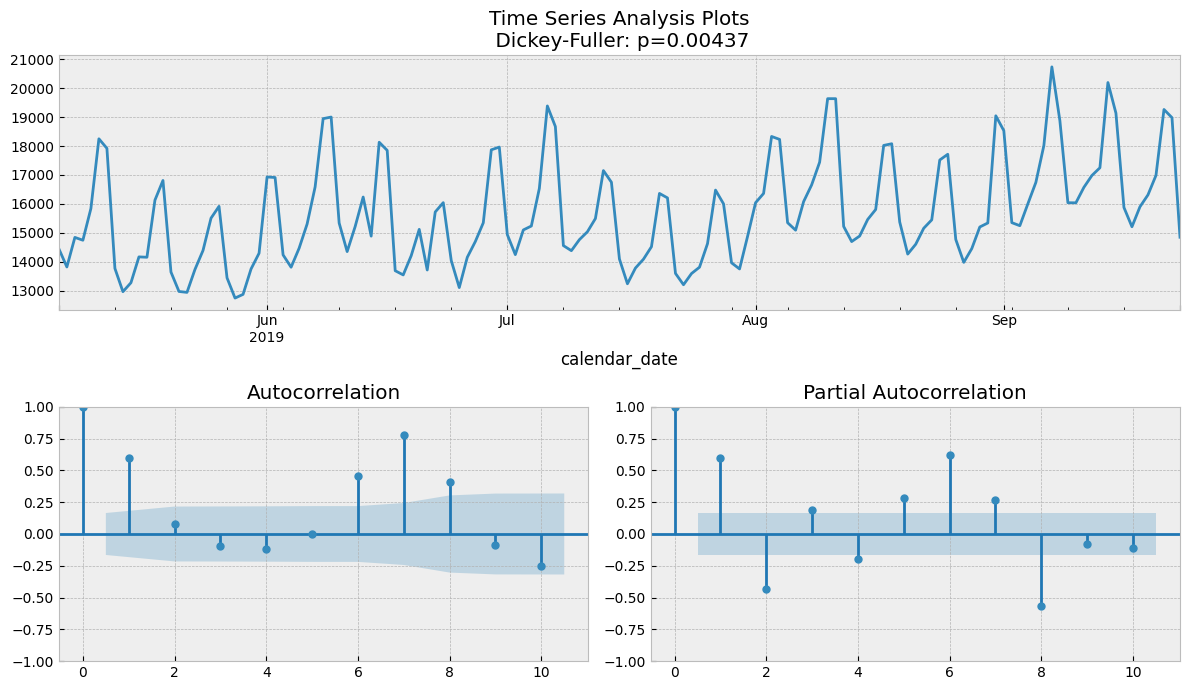

In [14]:
tsplot(df['total_trip'],lags = 10)

Orde non seasonal:
* p : [0,1,2]
* d : 0
* q : [0,1]

## Menghilangkan efek seasonal

In [15]:
# Lakukan differencing musiman pada variabel endogen dengan periode 7 (mingguan)
df1_log_diff_seas = df['total_trip'].diff(7)

# Buat DataFrame baru untuk menyimpan hasil differencing
df_diff_seas = pd.DataFrame({
    'total_trip_diff': df1_log_diff_seas,
    'holiday': df['holiday'],
    'is_weekend': df['is_weekend']
})
# Hapus baris yang mengandung nilai NaN
df_diff_seas = df_diff_seas.dropna()

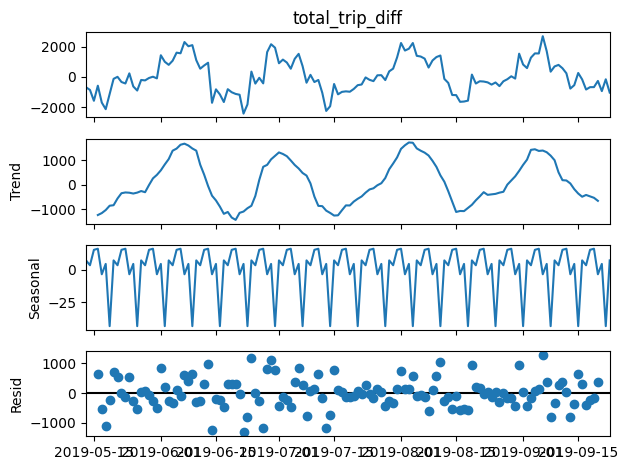

In [16]:
# Tampilkan plot decompose
dec = sm.tsa.seasonal_decompose(df_diff_seas['total_trip_diff']).plot()
plt.show()

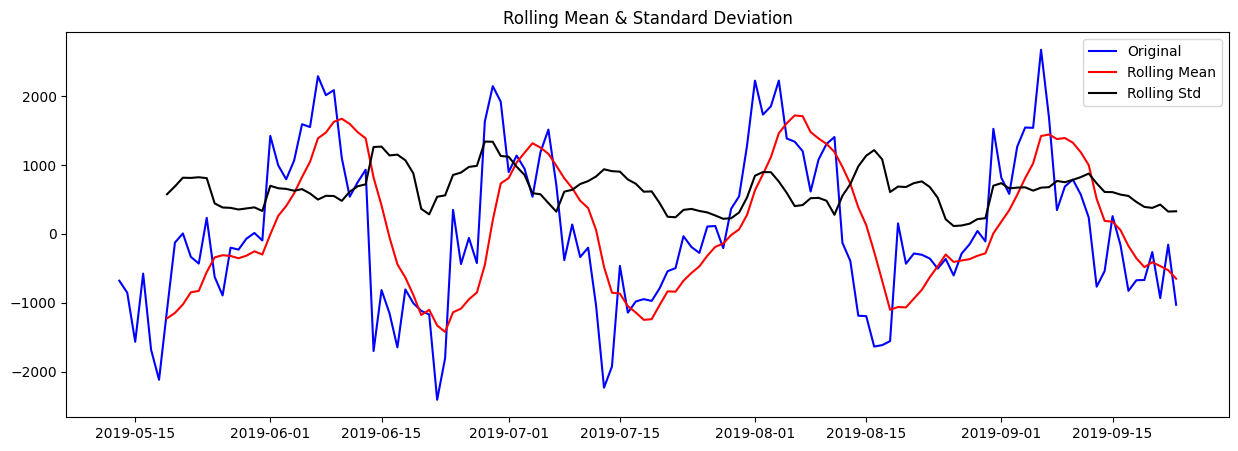

Results of Dickey-Fuller Test:
Test Statistic                -6.241104e+00
p-value                        4.695011e-08
#Lags Used                     1.300000e+01
Number of Observations Used    1.200000e+02
Critical Value (1%)           -3.486056e+00
Critical Value (5%)           -2.885943e+00
Critical Value (10%)          -2.579785e+00
dtype: float64


In [17]:
test_stationarity(df_diff_seas['total_trip_diff'])

p-value<0.05, H0 ditolak, data stasioner

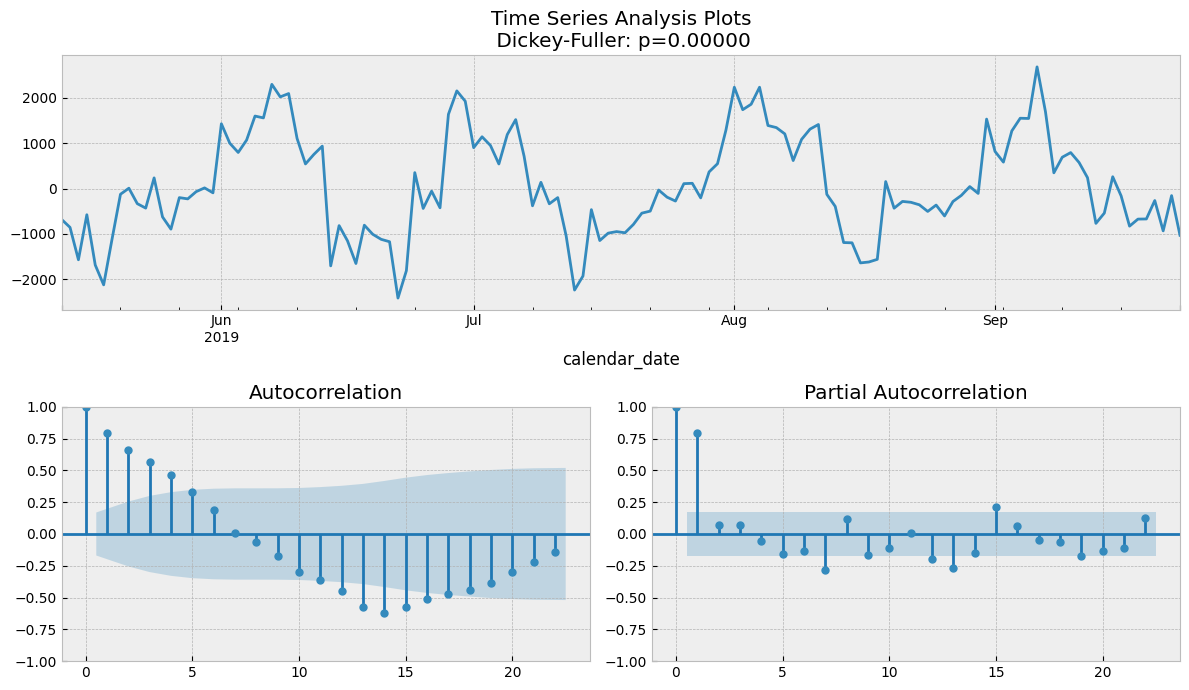

In [18]:
tsplot(df_diff_seas['total_trip_diff'])

Orde seasonal:
* p : [0,1]
* d : 0
* q : [0,1,2,3]
* s : 7

## Orde model yang akan tuning

In [19]:
# Orde Non Seasonal
p = [0,1,2] # Orde AR
d = 0
q = [0,1] # Orde MA

# Orde Seasonal
P = [0,1] # Orde AR Seasonal
D = 0
Q = [0,1,2,3] # Orde MA Seasonal
s = 7 #(7 hari)

## Model SARIMA

In [20]:
import itertools
from sklearn.metrics import mean_squared_error
import time

# Gabungkan semua kombinasi nilai parameter
param_combinations = list(itertools.product(p, q, P, Q))
total_comb = len(p)*1*len(q)*len(P)*1*len(Q)
print(f"Total kombinasi model: {total_comb} kombinasi")

best_score = float("inf")
best_params = None
no = 1
# Lakukan grid search untuk setiap kombinasi parameter
for param in param_combinations:
    try:
        start_time = time.time()
        # Buat dan latih model SARIMA dengan musiman setiap 24 jam
        print(f"{no}. Model: SARIMA({param[0]},{d},{param[1]})({param[2]},{D},{param[3]}){s}")
        no += 1
        model = sm.tsa.SARIMAX(df_train['total_trip'], order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 7))
        results = model.fit()
        if elapsed_time > 300:  # Jika waktu pelatihan melebihi 5 menit (300 detik)
            print("Waktu pelatihan melebihi batas 5 menit, melanjutkan ke parameter selanjutnya...")
            print("====================================================================================")
            continue
        prediksi = results.predict(start=df_train.index[0], end=df_train.index[-1])
        mse = mean_squared_error(df_train['total_trip'], prediksi)
        rmse = np.sqrt(mse)
        elapsed_time = time.time() - start_time
        print(f"Nilai RMSE: {rmse}")
        print(f"Duration: {elapsed_time}")
        print("====================================================================================")
        if rmse < best_score:
            best_score = rmse
            best_params = param     
    except Exception as e:
        print("Model ini eror:", e)
        elapsed_time = time.time() - start_time
        print(f"Duration: {elapsed_time}")
        print("====================================================================================")
        continue

print("Best Parameters:", best_params)
print("Best RMSE:", best_score)

Total kombinasi model: 48 kombinasi
1. Model: SARIMA(0,0,0)(0,0,0)7
Model ini eror: name 'elapsed_time' is not defined
Duration: 0.032305002212524414
2. Model: SARIMA(0,0,0)(0,0,1)7
Nilai RMSE: 8967.159674801807
Duration: 0.06458854675292969
3. Model: SARIMA(0,0,0)(0,0,2)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Nilai RMSE: 6183.632948648436
Duration: 0.16871333122253418
4. Model: SARIMA(0,0,0)(0,0,3)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Nilai RMSE: 5198.776290526211
Duration: 0.38944554328918457
5. Model: SARIMA(0,0,0)(1,0,0)7
Nilai RMSE: 4096.1421128249185
Duration: 0.016748666763305664
6. Model: SARIMA(0,0,0)(1,0,1)7
Nilai RMSE: 4091.8484072000283
Duration: 0.08580732345581055
7. Model: SARIMA(0,0,0)(1,0,2)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Nilai RMSE: 4036.770944554731
Duration: 0.24451780319213867
8. Model: SARIMA(0,0,0)(1,0,3)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Nilai RMSE: 4034.458739692995
Duration: 0.3285865783691406
9. Model: SARIMA(0,0,1)(0,0,0)7
Nilai RMSE: 8051.97049549026
Duration: 0.03421425819396973
10. Model: SARIMA(0,0,1)(0,0,1)7
Nilai RMSE: 4970.317822573614
Duration: 0.12847900390625
11. Model: SARIMA(0,0,1)(0,0,2)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting par

Nilai RMSE: 3949.1354778905375
Duration: 0.27648115158081055
12. Model: SARIMA(0,0,1)(0,0,3)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  wa

Nilai RMSE: 3347.1232941063927
Duration: 0.508906364440918
13. Model: SARIMA(0,0,1)(1,0,0)7
Nilai RMSE: 2710.388735371675
Duration: 0.16559886932373047
14. Model: SARIMA(0,0,1)(1,0,1)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Nilai RMSE: 2879.799575781427
Duration: 0.3255910873413086
15. Model: SARIMA(0,0,1)(1,0,2)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Nilai RMSE: 2724.9955972704533
Duration: 0.39948177337646484
16. Model: SARIMA(0,0,1)(1,0,3)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Nilai RMSE: 3734.5509808401857
Duration: 0.5813910961151123
17. Model: SARIMA(1,0,0)(0,0,0)7
Nilai RMSE: 2067.769577455583
Duration: 0.009999513626098633
18. Model: SARIMA(1,0,0)(0,0,1)7
Nilai RMSE: 1734.0772769883583
Duration: 0.09910130500793457
19. Model: SARIMA(1,0,0)(0,0,2)7
Nilai RMSE: 1678.8706659275565
Duration: 0.28844785690307617
20. Model: SARIMA(1,0,0)(0,0,3)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Nilai RMSE: 1641.3811764679842
Duration: 0.5696752071380615
21. Model: SARIMA(1,0,0)(1,0,0)7
Nilai RMSE: 1562.3499631546088
Duration: 0.15556645393371582
22. Model: SARIMA(1,0,0)(1,0,1)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Nilai RMSE: 1515.2322599074919
Duration: 0.1974501609802246
23. Model: SARIMA(1,0,0)(1,0,2)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Nilai RMSE: 1513.3694748798632
Duration: 0.4114096164703369
24. Model: SARIMA(1,0,0)(1,0,3)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Nilai RMSE: 1581.3081262468506
Duration: 0.6180219650268555
25. Model: SARIMA(1,0,1)(0,0,0)7
Nilai RMSE: 2008.3011486821274
Duration: 0.044036865234375
26. Model: SARIMA(1,0,1)(0,0,1)7
Nilai RMSE: 1734.0334598944412
Duration: 0.13397622108459473
27. Model: SARIMA(1,0,1)(0,0,2)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Nilai RMSE: 1680.2351862495823
Duration: 0.36222195625305176
28. Model: SARIMA(1,0,1)(0,0,3)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 1640.5501772522914
Duration: 0.5516633987426758
29. Model: SARIMA(1,0,1)(1,0,0)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Nilai RMSE: 1573.6742940713461
Duration: 0.2622222900390625
30. Model: SARIMA(1,0,1)(1,0,1)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Nilai RMSE: 1517.7154689520432
Duration: 0.37055540084838867
31. Model: SARIMA(1,0,1)(1,0,2)7
Nilai RMSE: 1532.5380484049035
Duration: 0.4277222156524658
32. Model: SARIMA(1,0,1)(1,0,3)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting p

Nilai RMSE: 1514.619719686077
Duration: 0.765228271484375
33. Model: SARIMA(2,0,0)(0,0,0)7
Nilai RMSE: 2052.674931053641
Duration: 0.027269363403320312
34. Model: SARIMA(2,0,0)(0,0,1)7
Nilai RMSE: 1731.707665417807
Duration: 0.1424260139465332
35. Model: SARIMA(2,0,0)(0,0,2)7
Nilai RMSE: 1678.6896613364602
Duration: 0.25914645195007324
36. Model: SARIMA(2,0,0)(0,0,3)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 1642.279279789735
Duration: 0.5324082374572754
37. Model: SARIMA(2,0,0)(1,0,0)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Nilai RMSE: 1567.5577830401537
Duration: 0.245985746383667
38. Model: SARIMA(2,0,0)(1,0,1)7
Nilai RMSE: 1539.180720367716
Duration: 0.15912580490112305
39. Model: SARIMA(2,0,0)(1,0,2)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Nilai RMSE: 1514.457307246982
Duration: 0.4387319087982178
40. Model: SARIMA(2,0,0)(1,0,3)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as

Nilai RMSE: 1549.7976772557627
Duration: 0.593724250793457
41. Model: SARIMA(2,0,1)(0,0,0)7
Nilai RMSE: 1979.0760387334124
Duration: 0.07961130142211914
42. Model: SARIMA(2,0,1)(0,0,1)7
Nilai RMSE: 1719.5004870575071
Duration: 0.22032546997070312
43. Model: SARIMA(2,0,1)(0,0,2)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check ml

Nilai RMSE: 1677.8312201663916
Duration: 0.3397653102874756
44. Model: SARIMA(2,0,1)(0,0,3)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Nilai RMSE: 1639.4316698488851
Duration: 0.556114673614502
45. Model: SARIMA(2,0,1)(1,0,0)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting

Nilai RMSE: 1581.524017371362
Duration: 0.30217885971069336
46. Model: SARIMA(2,0,1)(1,0,1)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as startin

Nilai RMSE: 1521.0975926560693
Duration: 0.4042997360229492
47. Model: SARIMA(2,0,1)(1,0,2)7
Nilai RMSE: 1607.4109068896828
Duration: 0.49611473083496094
48. Model: SARIMA(2,0,1)(1,0,3)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Model ini eror: LU decomposition error.
Duration: 1.1558659076690674
Best Parameters: (1, 0, 1, 2)
Best RMSE: 1513.3694748798632


### **MODEL TERBAIK**: SARIMA(1,0,0)(1,0,2)7 

# Model SARIMAX

In [21]:
best_score = float("inf")
best_params = None
no = 1
print(f"Total kombinasi model: {total_comb} kombinasi")
for param in param_combinations:
    try:
        # Buat dan latih model SARIMA dengan musiman setiap 24 jam
        print(f"{no}. Model: SARIMA({param[0]},{d},{param[1]})({param[2]},{D},{param[3]}){s}")
        no += 1
        model = sm.tsa.SARIMAX(df['total_trip'], exog=df[['holiday','is_weekend']], order=(param[0], 0, param[1]), seasonal_order=(param[2], 0, param[3], 7))
        results = model.fit()
        if elapsed_time > 300:  # Jika waktu pelatihan melebihi 5 menit (300 detik)
            print("Waktu pelatihan melebihi batas 5 menit, melanjutkan ke parameter selanjutnya...")
            print("====================================================================================")
            continue 
        prediksi = results.predict(start=df_train.index[0], end=df_train.index[-1], exog=df_train[['holiday', 'is_weekend']])
        mse = mean_squared_error(df_train['total_trip'], prediksi)
        rmse = np.sqrt(mse)
        elapsed_time = time.time() - start_time
        print(f"Nilai RMSE: {rmse}")
        print(f"Duration: {elapsed_time}")
        print("====================================================================================")
        if rmse < best_score:
            best_score = rmse
            best_params = param
      
    except Exception as e:
        print("Model ini eror:", e)
        elapsed_time = time.time() - start_time
        print(f"Duration: {elapsed_time}")
        print("====================================================================================")
        continue

print("Best Parameters:", best_params)
print("Best RMSE:", best_score)

Total kombinasi model: 48 kombinasi
1. Model: SARIMA(0,0,0)(0,0,0)7
Nilai RMSE: 12273.684612212466
Duration: 1.1779091358184814
2. Model: SARIMA(0,0,0)(0,0,1)7
Nilai RMSE: 7315.757574114656
Duration: 1.3112847805023193
3. Model: SARIMA(0,0,0)(0,0,2)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Nilai RMSE: 5546.320361354442
Duration: 1.7165954113006592
4. Model: SARIMA(0,0,0)(0,0,3)7
Nilai RMSE: 4619.209908587579
Duration: 2.2093982696533203
5. Model: SARIMA(0,0,0)(1,0,0)7
Nilai RMSE: 3308.7716258746113
Duration: 2.3666629791259766
6. Model: SARIMA(0,0,0)(1,0,1)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting par

Nilai RMSE: 3395.4109396293106
Duration: 2.6188571453094482
7. Model: SARIMA(0,0,0)(1,0,2)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Nilai RMSE: 3394.1362745283814
Duration: 2.9933464527130127
8. Model: SARIMA(0,0,0)(1,0,3)7
Nilai RMSE: 5558.224452734098
Duration: 3.948925256729126
9. Model: SARIMA(0,0,1)(0,0,0)7
Nilai RMSE: 8047.546793262646
Duration: 4.009704828262329
10. Model: SARIMA(0,0,1)(0,0,1)7
Nilai RMSE: 4507.402581906436
Duration: 4.276060342788696
11. Model: SARIMA(0,0,1)(0,0,2)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Nilai RMSE: 4330.178289012789
Duration: 4.723834991455078
12. Model: SARIMA(0,0,1)(0,0,3)7
Nilai RMSE: 3810.613838387949
Duration: 5.400193691253662
13. Model: SARIMA(0,0,1)(1,0,0)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Nilai RMSE: 3063.5182196153232
Duration: 5.6912665367126465
14. Model: SARIMA(0,0,1)(1,0,1)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Nilai RMSE: 2801.079902367337
Duration: 6.071630001068115
15. Model: SARIMA(0,0,1)(1,0,2)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Nilai RMSE: 2792.0449660412432
Duration: 6.54179573059082
16. Model: SARIMA(0,0,1)(1,0,3)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 3012.695604229519
Duration: 7.625605583190918
17. Model: SARIMA(1,0,0)(0,0,0)7
Nilai RMSE: 1527.4675043743316
Duration: 7.753497362136841
18. Model: SARIMA(1,0,0)(0,0,1)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 1629.8410431573643
Duration: 8.068256378173828
19. Model: SARIMA(1,0,0)(0,0,2)7
Nilai RMSE: 3838.1225661109697
Duration: 8.473822355270386
20. Model: SARIMA(1,0,0)(0,0,3)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 3376.4240937108852
Duration: 9.13062834739685
21. Model: SARIMA(1,0,0)(1,0,0)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Nilai RMSE: 2181.137600164325
Duration: 9.462463617324829
22. Model: SARIMA(1,0,0)(1,0,1)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Nilai RMSE: 2395.0211211743963
Duration: 9.74953556060791
23. Model: SARIMA(1,0,0)(1,0,2)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Nilai RMSE: 2394.024644867147
Duration: 10.28301739692688
24. Model: SARIMA(1,0,0)(1,0,3)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 2725.8321175762717
Duration: 11.027581691741943
25. Model: SARIMA(1,0,1)(0,0,0)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 1677.7189817121853
Duration: 11.225507974624634
26. Model: SARIMA(1,0,1)(0,0,1)7
Nilai RMSE: 4780.012441007228
Duration: 11.437464714050293
27. Model: SARIMA(1,0,1)(0,0,2)7
Nilai RMSE: 5284.733340629366
Duration: 12.059682607650757
28. Model: SARIMA(1,0,1)(0,0,3)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 4387.682463923093
Duration: 13.05076813697815
29. Model: SARIMA(1,0,1)(1,0,0)7
Nilai RMSE: 3434.7421173953417
Duration: 13.303074359893799
30. Model: SARIMA(1,0,1)(1,0,1)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting par

Nilai RMSE: 2415.734989267418
Duration: 13.741432905197144
31. Model: SARIMA(1,0,1)(1,0,2)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Nilai RMSE: 2438.57592275407
Duration: 14.426521062850952
32. Model: SARIMA(1,0,1)(1,0,3)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 2641.1960688889485
Duration: 15.634854793548584
33. Model: SARIMA(2,0,0)(0,0,0)7
Nilai RMSE: 7646.95185095008
Duration: 15.664441347122192
34. Model: SARIMA(2,0,0)(0,0,1)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 2943.5514825758905
Duration: 15.966609477996826
35. Model: SARIMA(2,0,0)(0,0,2)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Nilai RMSE: 3832.5381180463896
Duration: 16.43317174911499
36. Model: SARIMA(2,0,0)(0,0,3)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 3366.7315581606113
Duration: 17.09772253036499
37. Model: SARIMA(2,0,0)(1,0,0)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Nilai RMSE: 12508360.988824928
Duration: 20.136743307113647
38. Model: SARIMA(2,0,0)(1,0,1)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Nilai RMSE: 2393.6845855513116
Duration: 20.55530333518982
39. Model: SARIMA(2,0,0)(1,0,2)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Nilai RMSE: 2623.4977552903542
Duration: 21.895183801651
40. Model: SARIMA(2,0,0)(1,0,3)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as

Nilai RMSE: 2494.2244196769234
Duration: 22.755558729171753
41. Model: SARIMA(2,0,1)(0,0,0)7
Nilai RMSE: 7174.005590675923
Duration: 22.80998730659485
42. Model: SARIMA(2,0,1)(0,0,1)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Nilai RMSE: 4216.42540582044
Duration: 23.197901248931885
43. Model: SARIMA(2,0,1)(0,0,2)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as startin

Nilai RMSE: 3831.8044480768644
Duration: 23.793734073638916
44. Model: SARIMA(2,0,1)(0,0,3)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Nilai RMSE: 3865.7859291640934
Duration: 24.704200983047485
45. Model: SARIMA(2,0,1)(1,0,0)7
Nilai RMSE: 2815.70462386343
Duration: 25.152402639389038
46. Model: SARIMA(2,0,1)(1,0,1)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle

Nilai RMSE: 2436.317488081143
Duration: 25.963125705718994
47. Model: SARIMA(2,0,1)(1,0,2)7


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting

Nilai RMSE: 12273.832690849125
Duration: 30.404623985290527
48. Model: SARIMA(2,0,1)(1,0,3)7
Nilai RMSE: 2584.04306938009
Duration: 31.40131139755249
Best Parameters: (1, 0, 0, 0)
Best RMSE: 1527.4675043743316


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### **MODEL TERBAIK**: SARIMAX(1,0,0)(0,0,0)7 

## Fit Model Terbaik

In [33]:
model_sea_1 = sm.tsa.SARIMAX(df['total_trip'], order=(1, 0, 0), seasonal_order=(1, 0, 2, 7))
model_sea_2 = sm.tsa.SARIMAX(df['total_trip'], exog=df[['holiday','is_weekend']], order=(1, 0, 0), seasonal_order=(0, 0, 0, 7))
all_models = [model_sea_1, model_sea_2]
all_fit_models = [] ; no = 0
nama_model = ['SARIMA(1,0,0)(1,0,2)7', 'SARIMAX(1,0,0)(0,0,0)7']
for i in all_models:
    model_seas_fit = i.fit()
    print("Model",nama_model[no])
    print(model_seas_fit.summary())
    all_fit_models.append(model_seas_fit)
    print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")

c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Model SARIMA(1,0,0)(1,0,2)7
                                       SARIMAX Results                                        
Dep. Variable:                             total_trip   No. Observations:                  141
Model:             SARIMAX(1, 0, 0)x(1, 0, [1, 2], 7)   Log Likelihood               -1099.764
Date:                                Sat, 10 Feb 2024   AIC                           2209.528
Time:                                        20:39:19   BIC                           2224.271
Sample:                                    05-06-2019   HQIC                          2215.519
                                         - 09-23-2019                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9127      0.036     25.291      0.000

c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


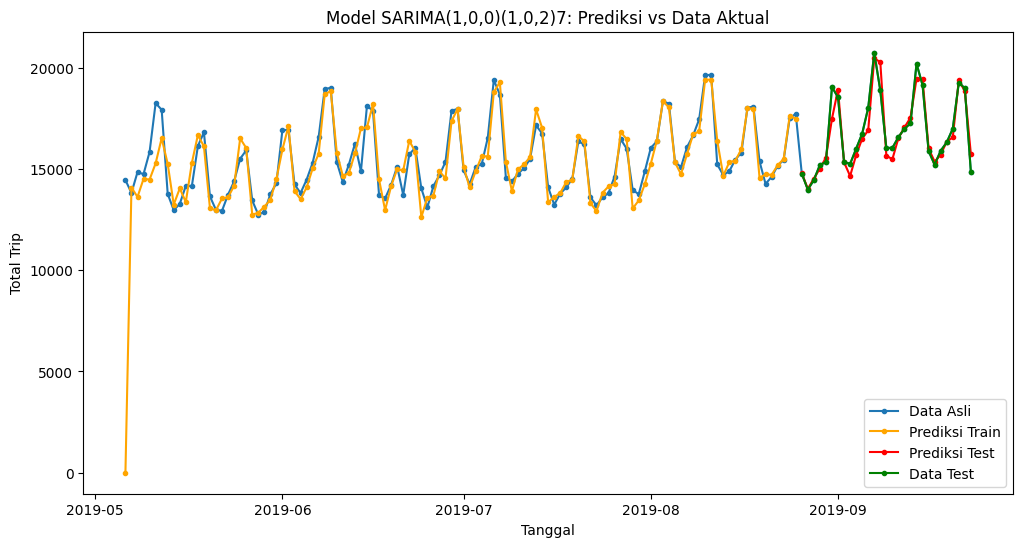

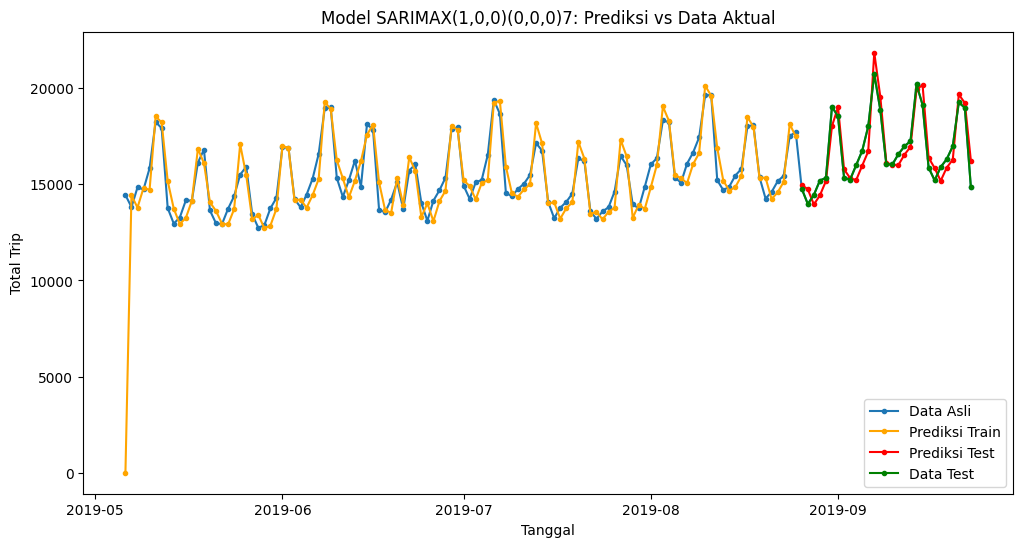

In [41]:
all_prediction_train = []
all_prediction_test = []
for i in range(len(all_fit_models)):
    if i == 0:
        prediction_train = all_fit_models[i].predict(start=df_train.index[0], end=df_train.index[-1])
        prediction_test = all_fit_models[i].predict(start=df_test.index[0], end=df_test.index[-1])
    else:
        prediction_train = all_fit_models[i].predict(start=df_train.index[0], end=df_train.index[-1], exog=df_test[['holiday', 'is_weekend']])
        prediction_test = all_fit_models[i].predict(start=df_test.index[0], end=df_test.index[-1], exog=df_test[['holiday', 'is_weekend']])
    all_prediction_train.append(prediction_train)
    all_prediction_test.append(prediction_test)
    # Plot prediksi dan data aktual
    plt.figure(figsize=(12, 6))
    plt.plot(df['total_trip'], label='Data Asli')
    plt.plot(df_train.index, prediction_train, label='Prediksi Train', color='orange')
    plt.plot(df_test.index, prediction_test, label='Prediksi Test', color='red')
    plt.plot(df_test.index, df_test['total_trip'], label='Data Test', color='green')
    plt.title(f'Model {nama_model[i]}: Prediksi vs Data Aktual')
    plt.xlabel('Tanggal')
    plt.ylabel('Total Trip')
    plt.legend()
    plt.show()

In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Hitung metrik evaluasi
for i in range(len(all_prediction_train)):
    print("Model",nama_model[i])
    rmse_train = np.sqrt(mean_squared_error(df_train['total_trip'], all_prediction_train[i])) ; rmse_test = np.sqrt(mean_squared_error(df_test['total_trip'], all_prediction_test[i]))
    mape_train = mean_absolute_percentage_error(df_train['total_trip'], all_prediction_train[i]) ; mape_test = mean_absolute_percentage_error(df_test['total_trip'], all_prediction_test[i])
    print(f"RMSE Train: {rmse_train} ; RMSE Test: {rmse_test}")
    print(f"MAPE Train: {mape_train} ; MAPE Test: {mape_test}")
    print("======================================================")

Model SARIMA(1,0,0)(1,0,2)7
RMSE Train: 1513.541605150858 ; RMSE Test: 548.753814178849
MAPE Train: 0.039563533204410216 ; MAPE Test: 0.021676729482450106
Model SARIMAX(1,0,0)(0,0,0)7
RMSE Train: 1527.4675043743316 ; RMSE Test: 677.9252199680277
MAPE Train: 0.04606265032875786 ; MAPE Test: 0.03452585910378909


# Generate tanggal untuk forecasting

In [25]:
import datetime

# Create a date range starting from September 24, 2019 to September 30, 2019
date_range = pd.date_range(start='2019-09-24', end='2019-09-30', freq='D')

# Create a DataFrame with the date range and columns for is_weekend and holiday
data_forecast = pd.DataFrame(index=date_range, columns=['is_weekend', 'holiday'])

# Fill in the is_weekend and holiday columns
for date in data_forecast.index:
    if date.weekday() >= 5:  # If Saturday or Sunday
        data_forecast.loc[date, 'is_weekend'] = 1
    else:
        data_forecast.loc[date, 'is_weekend'] = 0

    if np.random.rand() < 0.01:  # Assume 1% of days are holidays
        data_forecast.loc[date, 'holiday'] = 1
    else:
        data_forecast.loc[date, 'holiday'] = 0
    
    data_forecast.loc[date, 'total_trip'] = ''

# Convert columns to integer type
data_forecast['is_weekend'] = data_forecast['is_weekend'].astype(int)
data_forecast['holiday'] = data_forecast['holiday'].astype(int)

## Forecasting

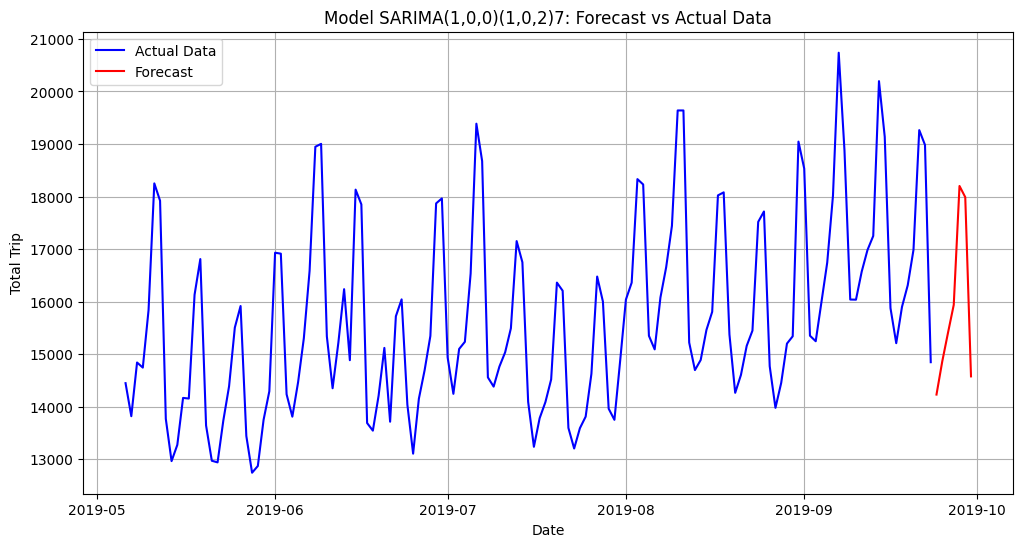

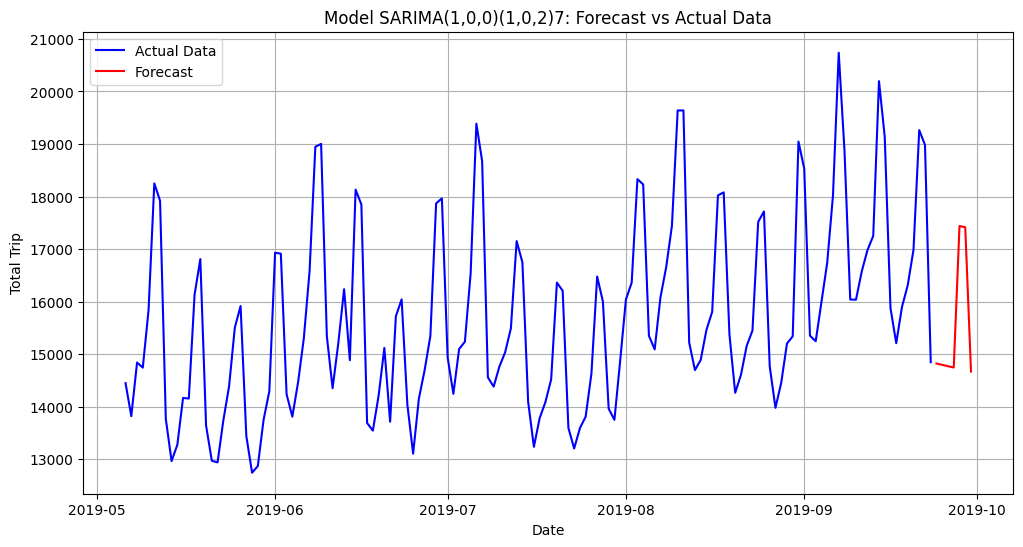

In [35]:
all_forecast = []
for i in range(len(all_fit_models)):
    if i==0:
        forecast = all_fit_models[i].forecast(steps=7)
    else:
        forecast = all_fit_models[i].forecast(steps=7, exog=data_forecast[['holiday','is_weekend']])

    all_forecast.append(forecast)
    # Plot the forecast along with the actual data
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['total_trip'], label='Actual Data', color='blue')
    plt.plot(data_forecast.index, forecast, label='Forecast', color='red')
    plt.title(f'Model {nama_model[0]}: Forecast vs Actual Data')
    plt.xlabel('Date')
    plt.ylabel('Total Trip')
    plt.legend()
    plt.grid(True)
    plt.show()

# Eksport Data

In [27]:
df_train['prediction_SARIMA'] = all_prediction_train[0]
df_test['prediction_SARIMA'] = all_prediction_test[0]
df_train['prediction_SARIMAX'] = all_prediction_train[1]
df_test['prediction_SARIMAX'] = all_prediction_test[1]

C:\Users\ramad\AppData\Local\Temp\ipykernel_29660\3550318382.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['prediction_SARIMA'] = all_prediction_train[0]
C:\Users\ramad\AppData\Local\Temp\ipykernel_29660\3550318382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['prediction_SARIMA'] = all_prediction_test[0]
C:\Users\ramad\AppData\Local\Temp\ipykernel_29660\3550318382.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [28]:
df_train.tail()

,total_trip,holiday,is_weekend,prediction_SARIMA,prediction_SARIMAX
calendar_date,,,,,
2019-08-21,14605,0,0,14708.705208,14239.603370
2019-08-22,15158,0,0,15177.569397,14580.020136
2019-08-23,15448,0,0,15497.898278,15132.074304
2019-08-24,17518,0,1,17621.763496,18141.027813
2019-08-25,17716,0,1,17482.823365,17492.689094


In [29]:
df_test.tail()

,total_trip,holiday,is_weekend,prediction_SARIMA,prediction_SARIMAX
calendar_date,,,,,
2019-09-19,16312,0,0,16350.981600,15872.805215
2019-09-20,16986,0,0,16555.665122,16284.100545
2019-09-21,19265,0,1,19379.048860,19676.397274
2019-09-22,18982,0,1,18838.477904,19236.701088
2019-09-23,14847,0,0,15728.102203,16234.735607


In [30]:
data_forecast['prediction_SARIMA'] = all_forecast[0]
data_forecast['prediction_SARIMAX'] = all_forecast[1]
data_forecast

,is_weekend,holiday,total_trip,prediction_SARIMA,prediction_SARIMAX
2019-09-24,0,0,,14230.534467,14821.606228
2019-09-25,0,0,,14860.733998,14796.255888
2019-09-26,0,0,,15407.526815,14770.948906
2019-09-27,0,0,,15938.695182,14745.685209
2019-09-28,1,0,,18201.529213,17439.914236
2019-09-29,1,0,,17988.055747,17414.736885
2019-09-30,0,0,,14576.710525,14670.153082


In [31]:
all_data = pd.concat([df_train,df_test,data_forecast])

In [32]:
all_data.to_csv(PATH_DATA_CLEAN+'trip_daily_prediction_dashboard.csv')